### Example Ground Motion Calculations for Normal Fault Event
# Daniel Trugman, 2024

# installation: pip install --upgrade pygmm

In [1]:
### Program Imports
import numpy as np
import matplotlib.pyplot as plt

# !pip install --upgrade pygmm # uncomment as needed
import pygmm

In [7]:
### Define earthquake scenario

# does not include distance information
event = pygmm.Scenario(
    mag = 6.4, # moment magnitude
    mechanism="NS", # normal slip
    dip = 60, # fault dip
    region="california", # controls attenuation, there is no "Nevada"
    v_s30=760, # site condition, this is considered neutral
    depth_tor=0.0, # tor=top of rupture, this is a surface rupture
    depth_bor=12.0, # bor=bottom of rupture
)

In [8]:
### Calculations for different distances

# fault parameters (see above)
ztor = 0.0
zbor = 12.0
dip = 60.0

# horizontal distance the dipping fault extends
xrup = (zbor-ztor) / np.tan(np.radians(dip))
print(f'xrup: {xrup}')

# perpindicular distance from fault trace
rxs = np.linspace(0, 300, 301)

# approximate rupture distance on the hanging wall (could be improved...)
xr = np.linspace(0, xrup, 1001)
zr = np.linspace(ztor, zbor, 1001)
rrups = np.zeros_like(rxs)
for ii, xx in enumerate(rxs):
    dist = np.sqrt((xr-xx)**2 + zr**2)
    rrups[ii] = np.min(dist)

# Rjb is like Rrup but in map view
rjbs = np.where(rxs <= xrup, 0.0, rxs-xrup)

# loop over distances to calculate pgv 
pgv_med= np.zeros_like(rxs)
lpgv_std = np.zeros_like(rxs)
for ii in range(pgv_med.size):

    # distance-specific scenario
    scen = event.copy_with(dist_rup=rrups[ii], dist_x=rxs[ii], dist_jb=rjbs[ii], on_hanging_wall=True)

    # calculate ground motion for a particular model
    model = pygmm.AbrahamsonSilvaKamai2014(scen)

    # we'll track the median pgv and its standard deviation (ln units)
    pgv_med[ii] = model.pgv # cm/s
    lpgv_std[ii] = model.ln_std_pgv # ln cm/s


xrup: 6.928203230275511


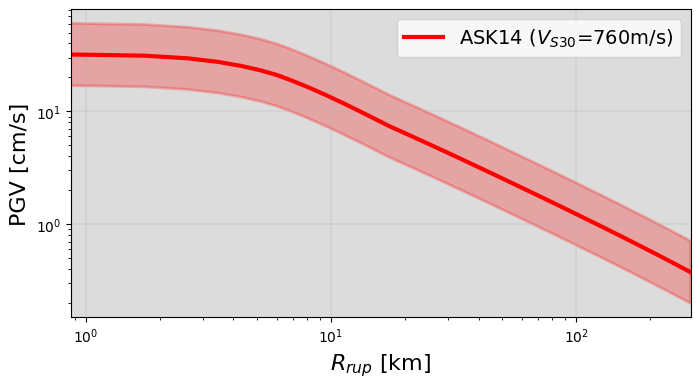

In [9]:
### PGV Plot

# figure setup
fig, axi = plt.subplots(figsize=(8,4))
axi.set_facecolor("gainsboro")

# plot GMPE
ly1 = np.log(pgv_med)-lpgv_std
ly2 = np.log(pgv_med)+lpgv_std
axi.fill_between(x=rrups,y1=np.exp(ly1),y2=np.exp(ly2),color="r",alpha=0.25,lw=2)
axi.loglog(rrups,pgv_med,"-r",lw=3,label="ASK14 ($V_{S30}$=760m/s)")

# formatting
axi.set_xlabel("$R_{rup}$ [km]",fontsize=16)
axi.set_ylabel("PGV [cm/s]",fontsize=16)
axi.grid(lw=0.3)
axi.legend(loc="upper right",fontsize=14)
axi.set_xlim(rrups[1],rrups[-1])

# show 
plt.show()